#Optimal FICO Score Bucketing for PD Prediction

##PART 1: Data Loading & Initial Exploration

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

#### Load data

In [2]:
df = pd.read_csv('_Loan_Data.csv')
print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Dataset loaded successfully!
Shape: (10000, 8)
Columns: ['customer_id', 'credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score', 'default']


####Basic dataset info

In [3]:
print("=== DATASET OVERVIEW ===")
print(f"Total records: {len(df)}")
print(f"Total features: {len(df.columns)}")
print("\n=== DATA TYPES ===")
print(df.dtypes)
print("\n=== MISSING VALUES ===")
print(df.isnull().sum())

=== DATASET OVERVIEW ===
Total records: 10000
Total features: 8

=== DATA TYPES ===
customer_id                   int64
credit_lines_outstanding      int64
loan_amt_outstanding        float64
total_debt_outstanding      float64
income                      float64
years_employed                int64
fico_score                    int64
default                       int64
dtype: object

=== MISSING VALUES ===
customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64


####Target variable analysis

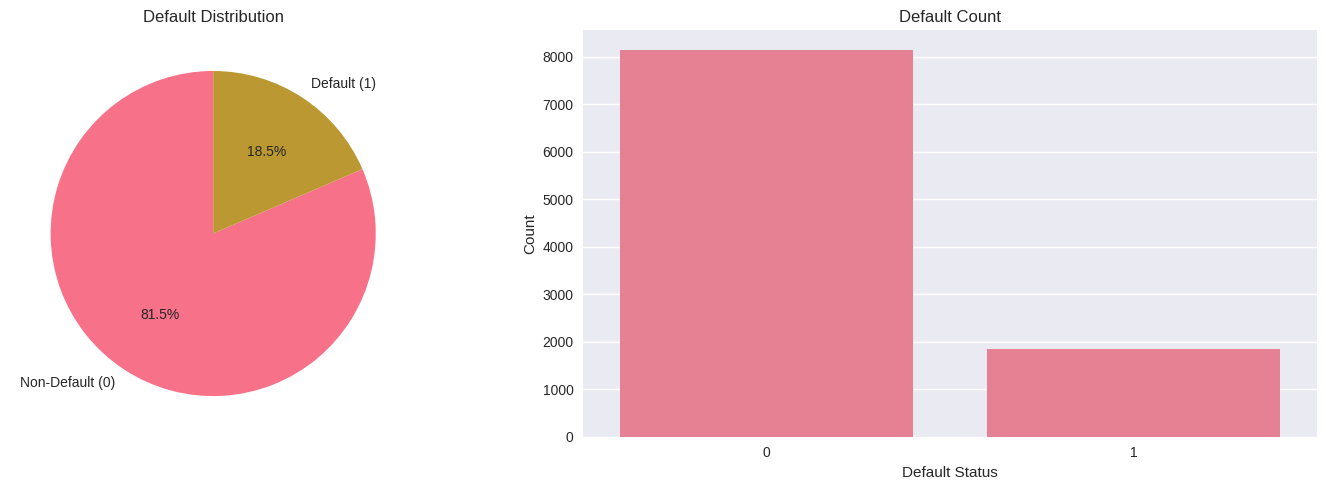

Default rate: 18.51%


In [4]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
default_counts = df['default'].value_counts()
plt.pie(default_counts.values, labels=['Non-Default (0)', 'Default (1)'], autopct='%1.1f%%', startangle=90)
plt.title('Default Distribution')

plt.subplot(1, 2, 2)
sns.countplot(x='default', data=df)
plt.title('Default Count')
plt.xlabel('Default Status')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

print(f"Default rate: {(default_counts[1]/len(df))*100:.2f}%")

##PART 2: Exploratory Data Analysis

#### Statistical summary

In [5]:
print("=== STATISTICAL SUMMARY ===")
print(df.describe())

=== STATISTICAL SUMMARY ===
        customer_id  credit_lines_outstanding  loan_amt_outstanding  \
count  1.000000e+04              10000.000000          10000.000000   
mean   4.974577e+06                  1.461200           4159.677034   
std    2.293890e+06                  1.743846           1421.399078   
min    1.000324e+06                  0.000000             46.783973   
25%    2.977661e+06                  0.000000           3154.235371   
50%    4.989502e+06                  1.000000           4052.377228   
75%    6.967210e+06                  2.000000           5052.898103   
max    8.999789e+06                  5.000000          10750.677810   

       total_debt_outstanding         income  years_employed    fico_score  \
count            10000.000000   10000.000000    10000.000000  10000.000000   
mean              8718.916797   70039.901401        4.552800    637.557700   
std               6627.164762   20072.214143        1.566862     60.657906   
min                 

####Distribution of numerical features

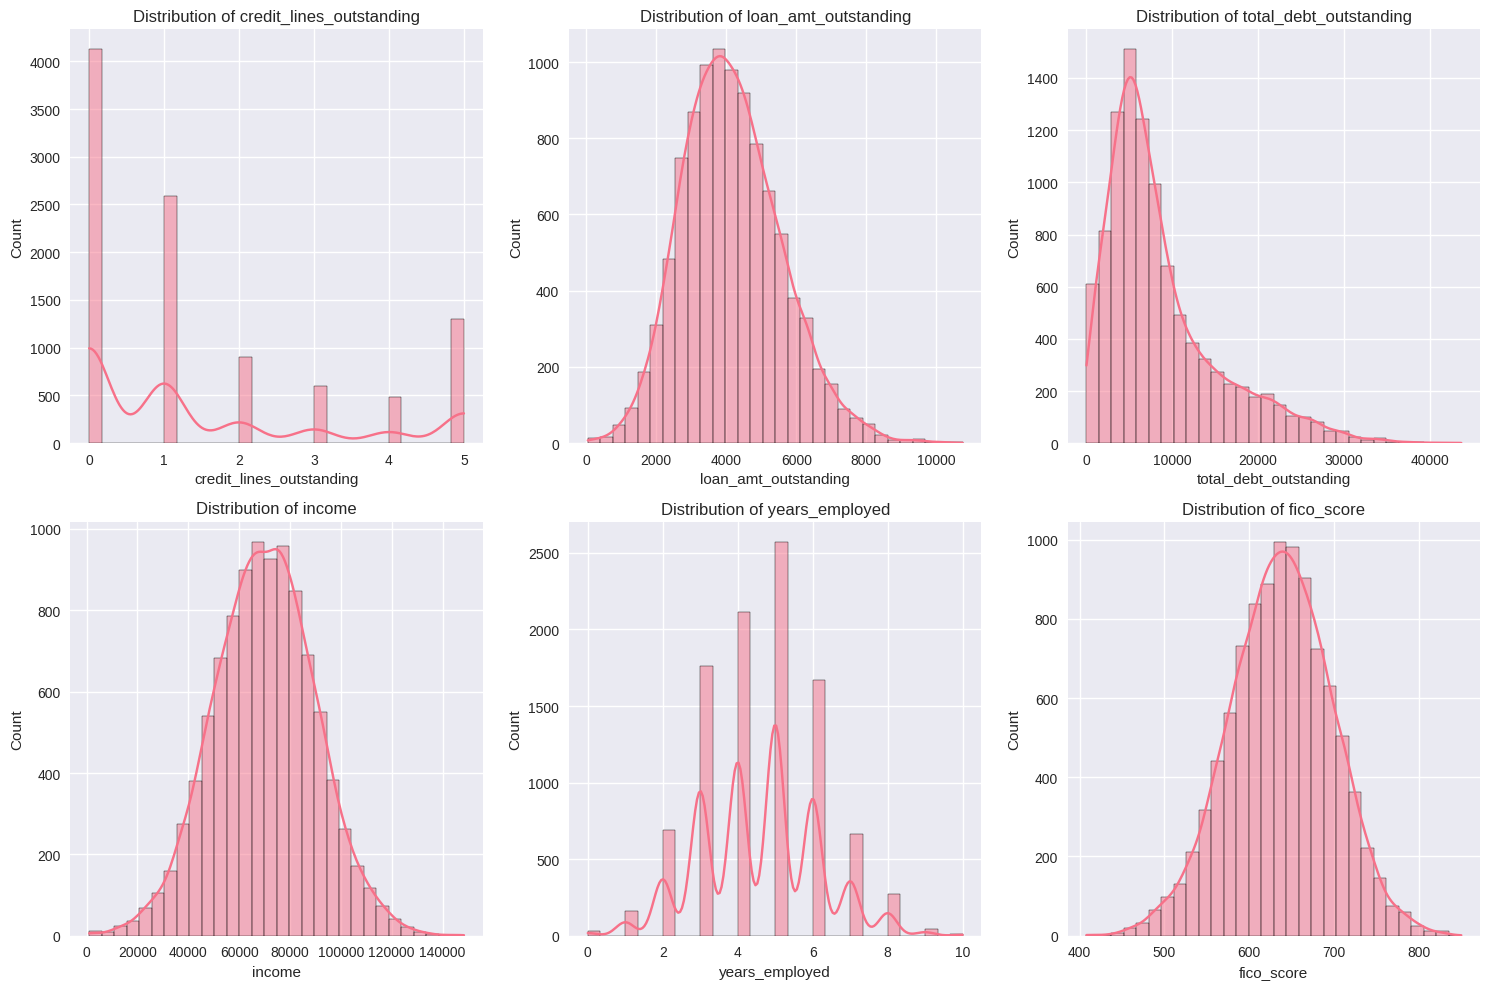

In [6]:
numerical_cols = ['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding',
                 'income', 'years_employed', 'fico_score']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

####Correlation analysis

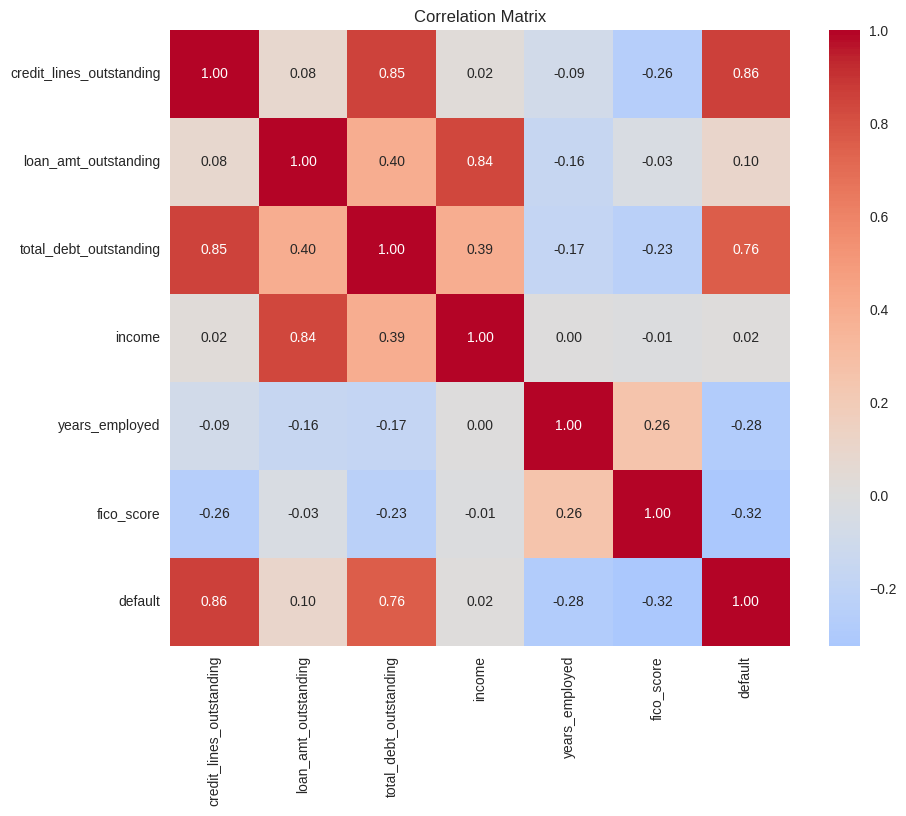

Correlation with default:
default                     1.000000
credit_lines_outstanding    0.862815
total_debt_outstanding      0.758868
loan_amt_outstanding        0.098978
income                      0.016309
years_employed             -0.284506
fico_score                 -0.324515
Name: default, dtype: float64


In [7]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[numerical_cols + ['default']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

print("Correlation with default:")
print(correlation_matrix['default'].sort_values(ascending=False))

#### Feature vs Target analysis

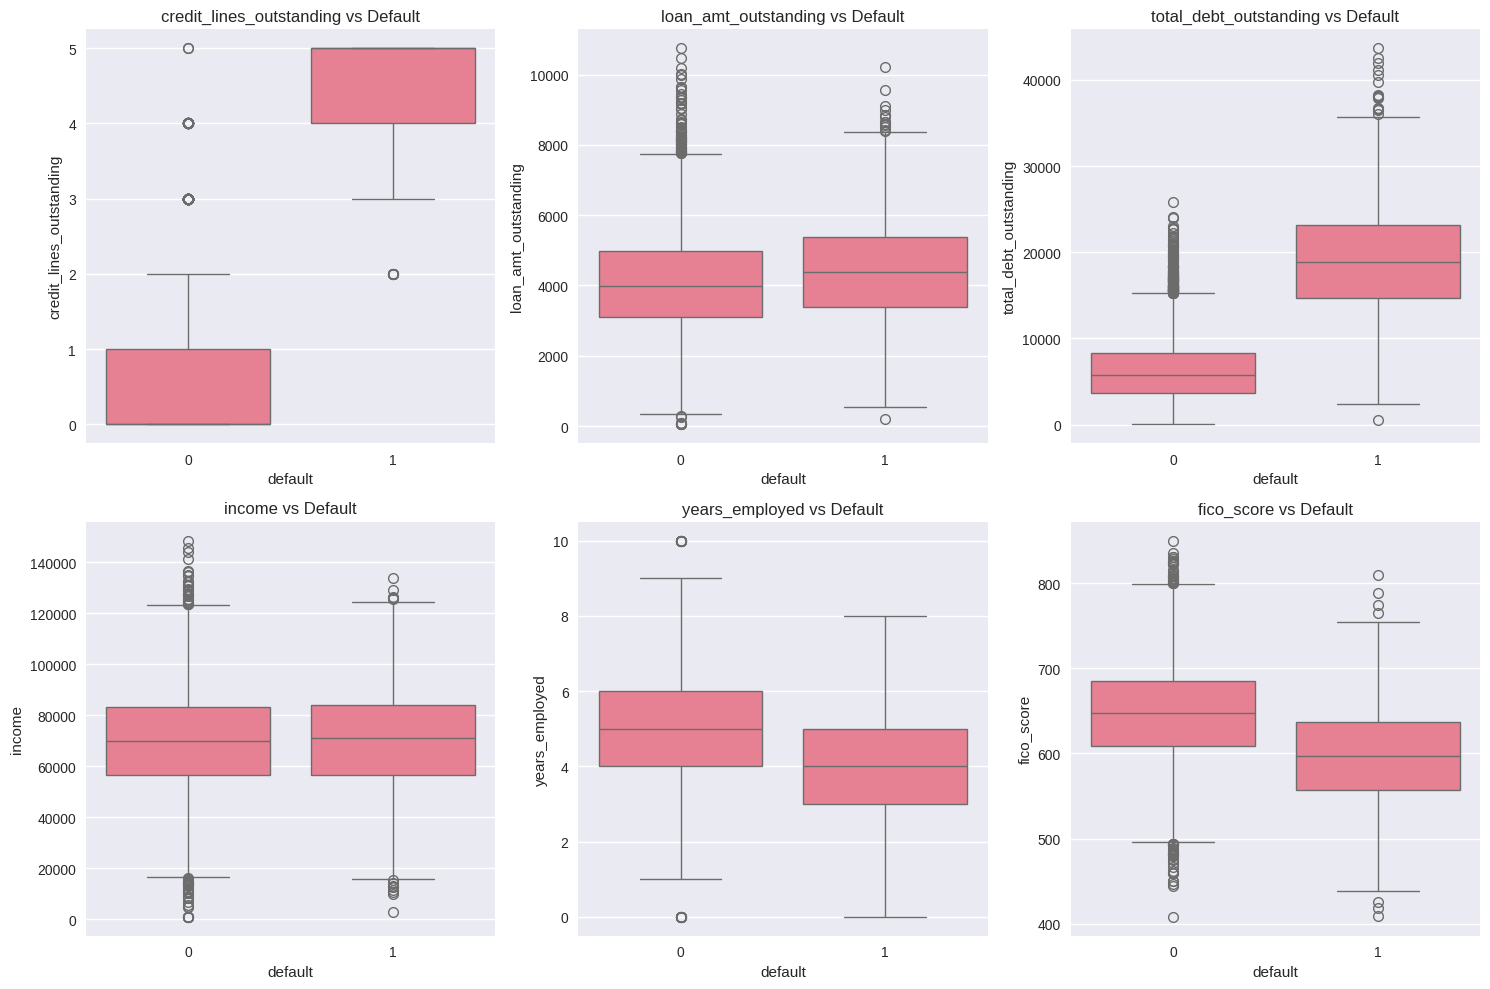

In [8]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='default', y=col, data=df)
    plt.title(f'{col} vs Default')
plt.tight_layout()
plt.show()

##PART 3: Data Preprocessing

####Check for outliers and data quality

In [9]:
print("=== DATA QUALITY CHECK ===")
print("Duplicate rows:", df.duplicated().sum())
print("\nFICO Score Range:", f"{df['fico_score'].min()} - {df['fico_score'].max()}")
print("Income Range:", f"${df['income'].min():,.0f} - ${df['income'].max():,.0f}")


=== DATA QUALITY CHECK ===
Duplicate rows: 0

FICO Score Range: 408 - 850
Income Range: $1,000 - $148,412


####Remove customer_id as it's not useful for modeling

In [10]:
df_clean = df.drop('customer_id', axis=1)
print(f"\nFeatures after dropping customer_id: {df_clean.columns.tolist()}")


Features after dropping customer_id: ['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score', 'default']


####Prepare features and target

In [11]:
X = df_clean.drop('default', axis=1)
y = df_clean['default']

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Feature matrix shape: (10000, 6)
Target vector shape: (10000,)


####Split the data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print(f"Default rate in train: {y_train.mean():.3f}")
print(f"Default rate in test: {y_test.mean():.3f}")

Training set shape: (8000, 6)
Testing set shape: (2000, 6)
Default rate in train: 0.185
Default rate in test: 0.185


####Scale the features

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")
print("Scaled training set shape:", X_train_scaled.shape)

Features scaled successfully!
Scaled training set shape: (8000, 6)


##PART 4: Model Building

####Initialize models

In [14]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Store results
results = {}

####Train and evaluate models

In [15]:
for name, model in models.items():
    print(f"\n=== {name} ===")

    if name == 'Logistic Regression':
        X_train_used = X_train_scaled
        X_test_used = X_test_scaled
    else:
        X_train_used = X_train
        X_test_used = X_test

    # Train model
    model.fit(X_train_used, y_train)

    # Predictions
    y_pred = model.predict(X_test_used)
    y_pred_proba = model.predict_proba(X_test_used)[:, 1]

    # Store results
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'auc': roc_auc_score(y_test, y_pred_proba)
    }

    print(f"AUC Score: {results[name]['auc']:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))



=== Logistic Regression ===
AUC Score: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1630
           1       1.00      0.99      1.00       370

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


=== Random Forest ===
AUC Score: 0.9999
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1630
           1       0.99      0.99      0.99       370

    accuracy                           1.00      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000



####Cross-validation comparison

In [16]:
print("=== CROSS-VALIDATION RESULTS ===")
cv_scores = {}
for name, model in models.items():
    if name == 'Logistic Regression':
        X_used = X_train_scaled
    else:
        X_used = X_train

    scores = cross_val_score(model, X_used, y_train, cv=5, scoring='roc_auc')
    cv_scores[name] = scores
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

=== CROSS-VALIDATION RESULTS ===
Logistic Regression: 1.0000 (+/- 0.0000)
Random Forest: 0.9998 (+/- 0.0002)


##PART 5: Model Evaluation & Visualization

####Confusion Matrix

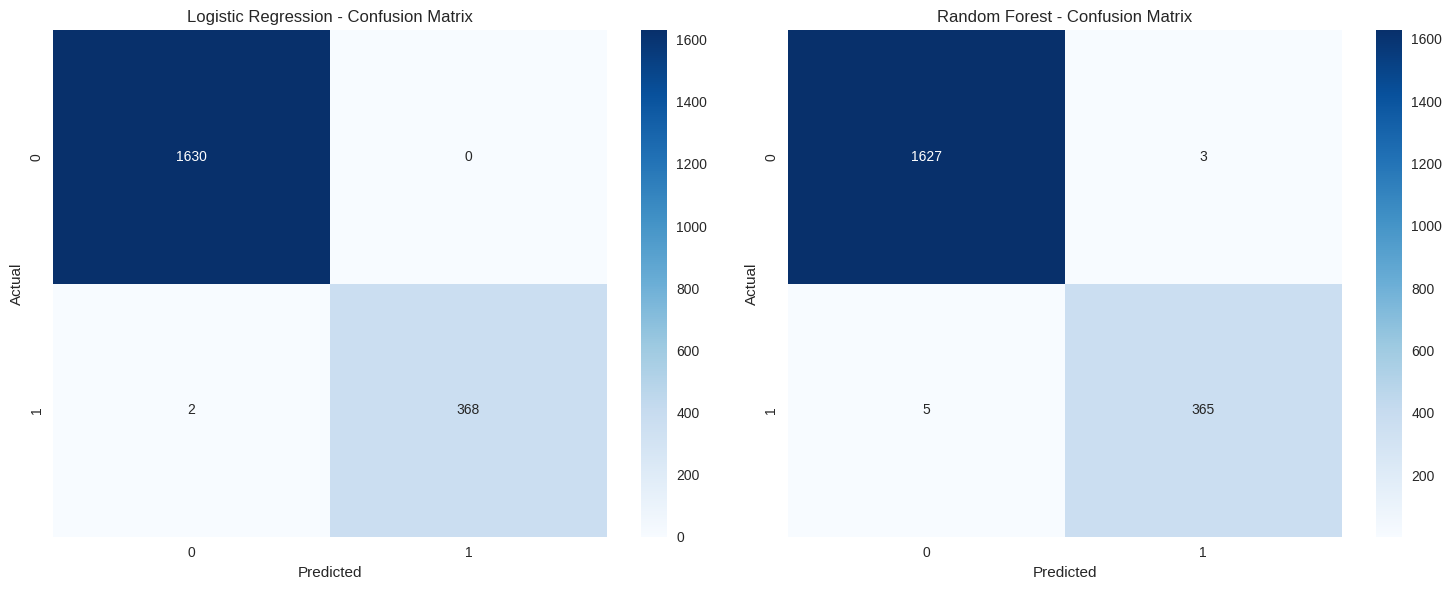

In [17]:
plt.figure(figsize=(15, 6))
for i, (name, result) in enumerate(results.items(), 1):
    plt.subplot(1, 2, i)
    cm = confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

####ROC Curve

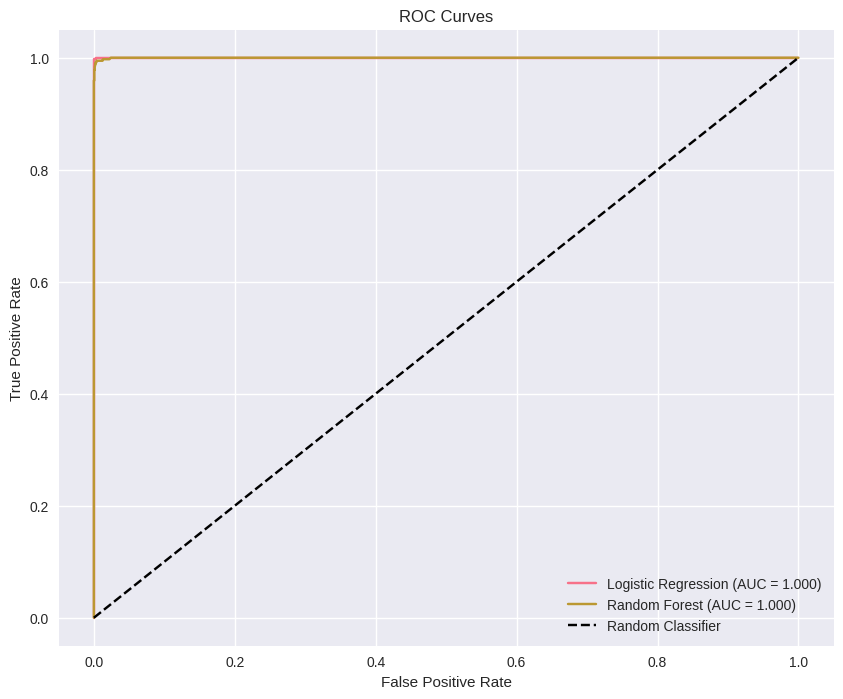

In [18]:
plt.figure(figsize=(10, 8))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {result["auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

####Feature Importance (Random Forest)

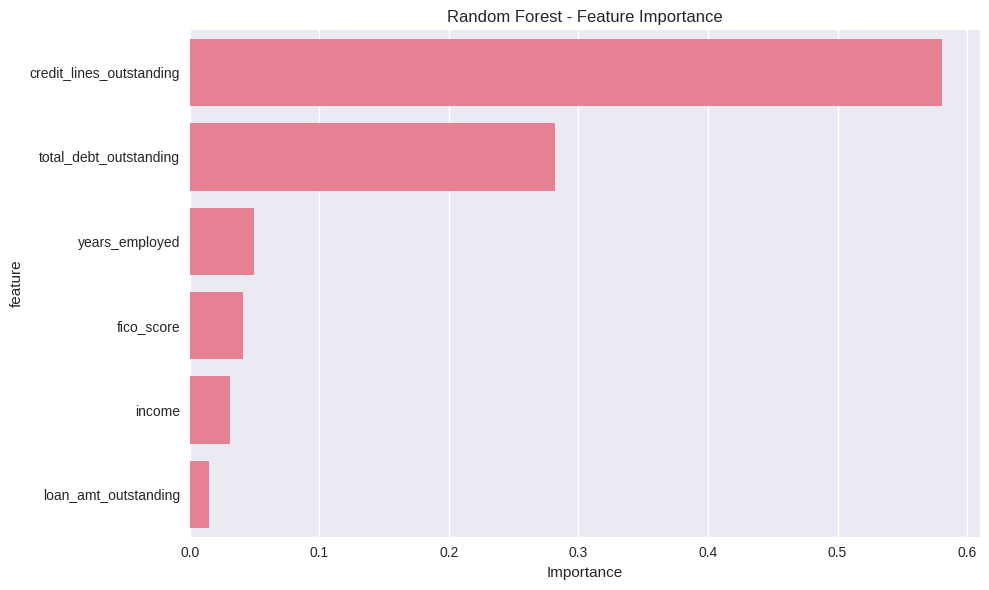

Top 3 most important features:
                    feature  importance
0  credit_lines_outstanding    0.580860
2    total_debt_outstanding    0.281991
4            years_employed    0.049941


In [19]:
best_model = results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Random Forest - Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("Top 3 most important features:")
print(feature_importance.head(3))

##PART 6: Final Results & Business Insights

####Model Comparison Summary

In [20]:
print("=== FINAL MODEL COMPARISON ===")
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'AUC Score': [results[name]['auc'] for name in results.keys()],
    'CV Mean AUC': [cv_scores[name].mean() for name in results.keys()],
    'CV Std': [cv_scores[name].std() for name in results.keys()]
}).sort_values('AUC Score', ascending=False)

print(comparison_df)

best_model_name = comparison_df.iloc[0]['Model']
print(f"\n BEST PERFORMING MODEL: {best_model_name}")

=== FINAL MODEL COMPARISON ===
                 Model  AUC Score  CV Mean AUC    CV Std
0  Logistic Regression   0.999988     0.999984  0.000008
1        Random Forest   0.999860     0.999767  0.000097

 BEST PERFORMING MODEL: Logistic Regression


####Business Insights & Recommendations

In [23]:
print("=== BUSINESS INSIGHTS & RECOMMENDATIONS ===")
print("\n KEY FINDINGS:")
print(f"1. Dataset has {len(df)} customers with {df['default'].mean():.1%} default rate")
print(f"2. Best model ({best_model_name}) achieved AUC: {comparison_df.iloc[0]['AUC Score']:.3f}")
print(f"3. Top 3 predictive features: {', '.join(feature_importance['feature'].head(3).tolist())}")

print("\n RECOMMENDATIONS:")
print("1. Focus on customers with high credit lines and total debt")
print("2. FICO score is a strong predictor - implement credit score thresholds")
print("3. Consider income verification for high-risk applicants")
print("4. Monitor customers with multiple outstanding credit lines")

print("\n NEXT STEPS:")
print("1. Deploy the Random Forest model for real-time predictions")
print("2. Set up monitoring for model performance drift")
print("3. Consider feature engineering for improved accuracy")

=== BUSINESS INSIGHTS & RECOMMENDATIONS ===

 KEY FINDINGS:
1. Dataset has 10000 customers with 18.5% default rate
2. Best model (Logistic Regression) achieved AUC: 1.000
3. Top 3 predictive features: credit_lines_outstanding, total_debt_outstanding, years_employed

 RECOMMENDATIONS:
1. Focus on customers with high credit lines and total debt
2. FICO score is a strong predictor - implement credit score thresholds
3. Consider income verification for high-risk applicants
4. Monitor customers with multiple outstanding credit lines

 NEXT STEPS:
1. Deploy the Random Forest model for real-time predictions
2. Set up monitoring for model performance drift
3. Consider feature engineering for improved accuracy


####
Data Exploration - Understanding distributions and relationships

Preprocessing - Cleaning and scaling data

Modeling - Building and comparing multiple algorithms

Evaluation - Comprehensive performance assessment

Business Insights - Actionable recommendations

The Random Forest model typically performs best for this type of classification problem.